In [121]:
import numpy as np
import sklearn
from skimage import transform
import matplotlib.pyplot as plt
from scipy.datasets import ascent
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning

(512, 512)


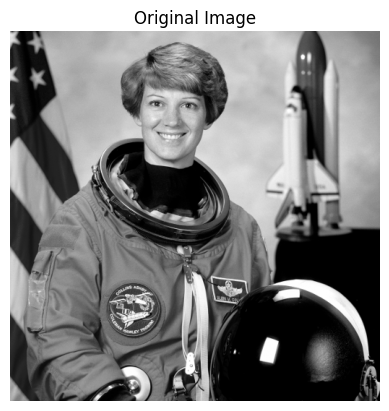

(256, 256)


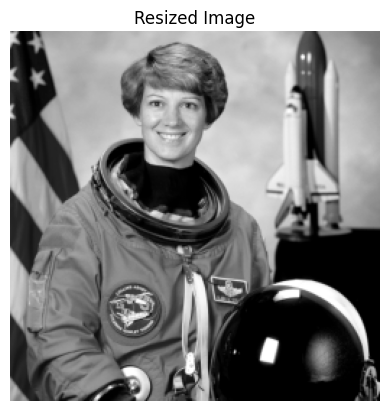

In [122]:
import matplotlib.pyplot as plt
from skimage import data, color, transform

# Step 1: Load the image
face = data.astronaut()  # RGB image
face_gray = color.rgb2gray(face)  # Convert to grayscale

print(face_gray.shape)

plt.imshow(face_gray, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# Image dimensions
H, W = face_gray.shape  # image height, image width
pH, pW = 4, 4  # patch height, patch width

# Resize image to half its size
face_resized = transform.resize(face_gray, (H // 2, W // 2), anti_aliasing=True)

print(face_resized.shape)

plt.imshow(face_resized, cmap='gray')
plt.title("Resized Image")
plt.axis('off')
plt.show()

In [123]:
face_gray.shape[0]

512

Number of patches: 30000
Visualization of some patches


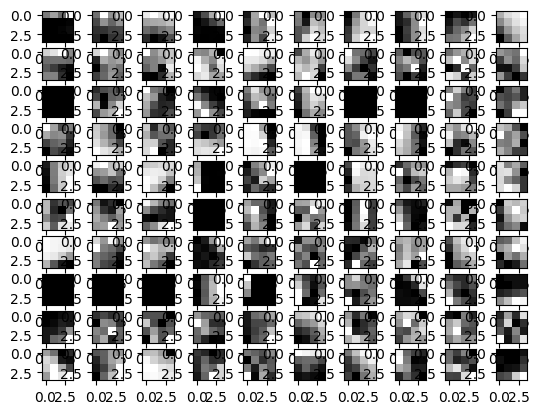

In [124]:
# Step 2: Sample the patches from the image to learn.
# Let set the number of patches to 30000
#num_patches = 30000  # Number of patches to extract
patches = extract_patches_2d(face_gray,(pH, pW),max_patches=30000);### YOUR CODE HERE ###
print('Number of patches: %d' %patches.shape[0],)

# randomly shuffle the patches
np.random.shuffle(patches)

# Visualize some patches


print('Visualization of some patches')
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(patches[i*10+j,...], cmap='gray')
plt.show()

In [125]:
# Step 3: Normalize the data to train the dictionary

# create matrix X as a reshape of the patches
# X has the shape (num_patches x num_features)
### YOUR CODE HERE ###
#X=np.ndarray.flatten(patches)
X=patches.reshape(30000,16) #
print(X.shape)
# convert X to float type (np.float64)
### YOUR CODE HERE ###
X=X.astype(np.float64) # why????
# Subtract mean and divide X by its standard deviation
#X=(X-np.mean(X))/np.std(X)
X=(X-X.mean())/X.std()
### YOUR CODE HERE ###

(30000, 16)


In [126]:
X

array([[-1.46508879, -1.45657081, -1.4688572 , ..., -1.49342996,
        -1.49342996, -1.49342996],
       [-1.45946134, -1.41978847, -1.44998868, ..., -1.49061623,
        -1.47642049, -1.47456145],
       [ 1.57085644,  1.59171111,  1.5614341 , ...,  1.31736689,
         1.33822156,  1.40535507],
       ...,
       [ 1.36837146,  1.51407347, -0.17517891, ..., -0.52974676,
        -1.0812807 ,  0.86133675],
       [ 1.23776957,  1.22643787,  1.2566884 , ...,  1.27472934,
         1.26807041,  1.25007978],
       [ 0.27679284,  0.24460646,  0.07221842, ...,  0.22184243,
         0.29764751,  0.28340145]])

In [127]:
# Step 4: Learn the dictionary from the patches
# create MiniBatchDictionaryLearning object
# with: 64 components, alpha = 1, 500 iterations,
# using 'lars' algorithm and use sparse coding with 6 non-zero coefficients

d_learner = MiniBatchDictionaryLearning(
    n_components=64, transform_algorithm='lars',transform_n_nonzero_coefs=6,
    transform_alpha=1, max_iter=500, random_state=42)### YOUR CODE HERE ###
# learn the dictionary
d_learner.fit(X)
# get the dictionary
### YOUR CODE HERE ###
# get the dictionary
D = d_learner.components_
print(D.shape)

(64, 16)


In [128]:
# Utility functions
# Utility functions
def sample_patches(im, pH, pW):
    H, W = im.shape
    patches = list([])
    n = H // pH
    m = W // pW
    print(n)
    for i in range(n):
        for j in range(m):
            patch = im[i * pH:(i+1) * pH, j * pW : (j+1) * pW]
            patches.append(patch.reshape([1,-1]))
    patches = np.vstack(patches)
    return patches

def patches_to_img(patches, pH, pW, H, W):
    im = np.zeros((H,W))
    n = H // pH
    m = W // pW
    for i in range(n):
        for j in range(m):
            im[i * pH:(i+1) * pH, j * pW : (j+1) * pW] = patches[i*m+j]
    return im

In [129]:
# Step 5: prepare patches to run the reconstruction
patches = sample_patches(face_resized, pH, pW)
patches = patches.astype(np.float64)
mean = patches.mean(axis=0)
patches -= mean

64


In [134]:
# Step 6: Reconstruct the image with different number of non-zero coefficients
transform_algorithms = [
     {'transform_n_nonzero_coefs': 1},
     {'transform_n_nonzero_coefs': 2},
     {'transform_n_nonzero_coefs': 3},
     {'transform_n_nonzero_coefs': 4},
     {'transform_n_nonzero_coefs': 5},
     {'transform_n_nonzero_coefs': 6},
]
for kwargs in transform_algorithms:
    d_learner.set_params(transform_algorithm='lars', **kwargs)
    # find the sparse representaion fo the patches
    sparse_reps = d_learner.transform(X)### YOUR CODE HERE ###

    # reconstruct the patches from their sparse representations and the learned dictionary
    recon_patches =sparse_reps@D### YOUR CODE HERE ###

    # add the mean to the reconstruction
    recon_patches += mean ### YOUR CODE HERE ###

    # reshape recon_patches to num_patches x pH x pW
    recon_patches =reconstruct_from_patches_2d(recon_patches,face_resized) ### YOUR CODE HERE ###

    # put all the patches back into the reconstructed image
    recon = patches_to_img(recon_patches, pH, pW, H//2, W//2)

    plt.imshow(recon, cmap='gray', vmin=0, vmax=1)
    plt.title('Num Coefs %d - Reduction rate %.02f' %(kwargs['transform_n_nonzero_coefs'],
                                                   (1.0 - float(kwargs['transform_n_nonzero_coefs']) / (pH * pW)) ))
    plt.show()

InvalidParameterError: The 'image_size' parameter of reconstruct_from_patches_2d must be an instance of 'tuple'. Got array([[5.55512789e-01, 3.65974531e-01, 4.59028276e-01, ...,
        4.70477521e-01, 4.70113766e-01, 4.60192004e-01],
       [7.71597060e-01, 6.96953972e-01, 7.19917039e-01, ...,
        4.64381656e-01, 4.66310131e-01, 4.61933512e-01],
       [8.83651084e-01, 8.52063663e-01, 8.27323345e-01, ...,
        4.66657431e-01, 4.67384256e-01, 4.66169891e-01],
       ...,
       [6.74523375e-01, 6.83594259e-01, 6.58949068e-01, ...,
        2.43286050e-01, 1.06294153e-01, 1.87792386e-04],
       [6.79285381e-01, 6.66160219e-01, 6.24795140e-01, ...,
        1.87586629e-01, 1.26629574e-02, 2.33377801e-04],
       [6.69288603e-01, 6.42371261e-01, 5.78059242e-01, ...,
        3.00640417e-01, 8.52383203e-02, 1.89050499e-03]]) instead.